In [65]:
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [66]:
SEED = 100
np.random.seed(SEED)
torch.manual_seed(SEED)

BATCH_SIZE = 256

In [67]:
device = torch.device("cuda")
print(device)

cuda


In [68]:
transform = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (1, 1, 1))])

data_set = ImageFolder("data/train", transform=transform)
n = len(data_set)
n_test = int(0.2 * n)
print(n, n_test, int(0.8*n))
test_train = torch.utils.data.random_split(data_set, [n_test, int(0.8*n)+1])

train_set = test_train[1]
test_set = test_train[0]
print(len(train_set), len(test_set))

88011 17602 70408
70409 17602


In [69]:
idx_to_class = {idx: classs for classs, idx in data_set.class_to_idx.items()}

In [70]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

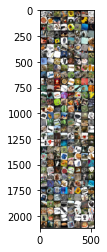

['spoon', 'monkey', 'flower', 'tomato', 'flower', 'carbon', 'truck', 'bicycle', 'worm', 'tea', 'worm', 'tea', 'memorial', 'tea', 'flower', 'camera', 'truck', 'elephant', 'spice', 'saw', 'flower', 'elephant', 'fish', 'gauge', 'bird', 'spoon', 'memorial', 'monkey', 'cat', 'nest', 'turtle', 'bacteria', 'tomato', 'tea', 'flower', 'motor', 'turtle', 'nest', 'bacteria', 'spice', 'truck', 'printer', 'bicycle', 'printer', 'corn', 'icecream', 'worm', 'cat', 'bacteria', 'hammer', 'tomato', 'spider', 'pot', 'camera', 'bicycle', 'kangaroo', 'antenna', 'bridge', 'corn', 'saw', 'snake', 'motor', 'icecream', 'tomato', 'elephant', 'acoustic', 'towel', 'frog', 'hammer', 'fungus', 'tea', 'squash', 'turtle', 'motor', 'pizza', 'memorial', 'bicycle', 'bomb', 'frog', 'fungus', 'crab', 'frog', 'bomb', 'pizza', 'hammer', 'fungus', 'spoon', 'worm', 'birch', 'nest', 'bread', 'antenna', 'worm', 'battery', 'turtle', 'echinoderm', 'birch', 'worm', 'towel', 'bacteria', 'icecream', 'egg', 'spider', 'flower', 'beetle

In [71]:
def imshow(img):
    img = img / 1 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print([idx_to_class[label] for label in list(labels.numpy())])

In [78]:
def conv_block(in_channels, out_channels, pool=False):
    if pool:
      return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(),
              nn.MaxPool2d(2))
    else:
      return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU())

class CustomResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.conv3 = conv_block(128, 256, pool=True)
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1024, pool=True)
        self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.avgpool = nn.AvgPool2d(4)
        self.fc1 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.res1(x) + x
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.conv5(x)
        x = self.res3(x) + x
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [79]:
model = CustomResNet(3, 50)

import torch.optim as optim
LEARN_RATE = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARN_RATE, weight_decay = 0.001)
print(device)
model.to(device=device)

cuda


CustomResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

acc_train = []
acc_epoch_train = []
acc_test = []
acc_epoch_test = []

model.train()

for epoch in range(25):

    losses_epoch_train = []
    losses_epoch_test = []
    acc_epoch_test = []
    acc_epoch_train = []

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        losses_epoch_train.append(loss.item())
        acc = (predictions.argmax(dim=1) == labels).sum() / predictions.shape[0]
        acc_epoch_train.append(acc.cpu())
    losses_train.append(np.mean(losses_epoch_train))
    acc_train.append(np.mean(acc_epoch_train))

    with torch.no_grad():
        for x, labels in testloader:
            x, labels = x.to(device), labels.to(device)
            predictions = model(x)
            loss = loss_fn(predictions, labels)
            losses_epoch_test.append(loss.item())
            acc = (predictions.argmax(dim=1) == labels).sum() / predictions.shape[0]
            acc_epoch_test.append(acc.cpu())
        losses_test.append(np.mean(losses_epoch_test))
        acc_test.append(np.mean(acc_epoch_test))

    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}, loss test: {losses_test[-1]:.3}")
    print(f"Epoch: {epoch}, acc train: {acc_train[-1]:.3}, acc test: {acc_test[-1]:.3}")

In [ ]:
plt.figure()
plt.grid(True)
plt.plot(losses_train)
plt.plot(losses_test)
plt.title("Loss")
plt.legend(["train", "valid"])

plt.figure()
plt.grid(True)
plt.title("Accuracy")
plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(["train", "valid"])
print('Finished Training')

In [ ]:
model.eval()

correct_pred = {classname: 0 for classname in list(idx_to_class.values())}
total_pred = {classname: 0 for classname in list(idx_to_class.values())}

with torch.no_grad():
  for i, data in enumerate(testloader, 0):
        images, labels = data    
        images = images.to(device)
        outputs = model(images).cpu()
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
          label = label.item()
          if label == prediction:
              correct_pred[idx_to_class[label]] += 1
          total_pred[idx_to_class[label]] += 1


print(f"Total Acc: { ( np.array(list(correct_pred.values())).sum() ) / ( np.array(list(total_pred.values())).sum() )}")

# print accuracy for each class
class_accs = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))
    class_accs.append(accuracy)

print(f"Avg class acc: {np.array(class_accs).mean()}")


In [ ]:
torch.save(model, "model")